## 0. Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import shutil
import random

import torch

from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from PIL import Image

import torch.nn as nn
import torch.optim as optim
from torchvision.models import mobilenet_v3_small

import pickle

## 1. Hyperparameters

In [ ]:
# Dataloaders
batch_size=32
num_workers=2

# Model Architecture
num_classes=16
lr=0.003

# Model Training
num_epochs=10

## 2. File Operations

In [ ]:
# All of the code has been implemented in the same cell to prevent duplication of directories

if os.path.exists("/content/common_dataset") and os.path.isdir("/content/common_dataset"):
    shutil.rmtree("/content/common_dataset")

if os.path.exists("/content/frames_lemon") and os.path.isdir("/content/frames_lemon"):
    shutil.rmtree("/content/frames_lemon")

if os.path.exists("/content/frames_potato") and os.path.isdir("/content/frames_potato"):
    shutil.rmtree("/content/frames_potato")

try:
    os.remove("/content/frames_lemon_cropped.zip")
    os.remove("/content/frames_potato_cropped.zip")
except:
    pass

# common_dataset

dirpath = "/content/common_dataset"
os.mkdir(dirpath)
os.mkdir(os.path.join(dirpath, "test"))
os.mkdir(os.path.join(dirpath, "train"))
for i in range(16):
    folder_name = "day_" + str(i)
    os.mkdir(os.path.join(dirpath, "test", folder_name))
    os.mkdir(os.path.join(dirpath, "train", folder_name))


#-----------------------------------------------------------------------------------------------------

# Downloading files from Google Drive

!gdown -q 1LDptivdf5VJCe9xa5gziUVN6hQoZ-3ZX # frames_lemon_cropped.zip
!gdown -q 1hhL3UxNG2EnlnISFSbXof-uv_7PexWqK # frames_potato_cropped.zip

!unzip -q /content/frames_lemon_cropped.zip -d /content/
!unzip -q /content/frames_potato_cropped.zip -d /content/

os.remove("/content/frames_lemon_cropped.zip")
os.remove("/content/frames_potato_cropped.zip")

#-----------------------------------------------------------------------------------------------------

# Renaming files

# frames_lemon

parent_dir = "/content/frames_lemon"
folder_list = os.listdir(parent_dir)

for day in folder_list:
    file_list = os.listdir(os.path.join(parent_dir, day))

    for image_file in file_list:
        old_file_name = os.path.join(parent_dir, day, image_file)
        modification = str(day) + "_" + image_file
        new_file_name = os.path.join(parent_dir, day, modification)
        os.rename(old_file_name, new_file_name)

# frames_potato

parent_dir = "/content/frames_potato"
folder_list = os.listdir(parent_dir)

for day in folder_list:
    file_list = os.listdir(os.path.join(parent_dir, day))

    for image_file in file_list:
        old_file_name = os.path.join(parent_dir, day, image_file)
        modification = str(day) + "_" + image_file
        new_file_name = os.path.join(parent_dir, day, modification)
        os.rename(old_file_name, new_file_name)

#-----------------------------------------------------------------------------------------------------

# Splitting data into train and test

tts_ratio = 0.8

# # potato_dataset
# parent_dir = "/content/frames_potato"
# class_list = os.listdir(parent_dir)

# for img_class in class_list:

#     file_list = os.listdir(os.path.join(parent_dir, img_class))
#     potato_random = random.sample(file_list, int(tts_ratio*len(file_list)))

#     for img_file in potato_random:
#         source_path = os.path.join(parent_dir, img_class, img_file)
#         destination_path = os.path.join("/content/common_dataset", "train", img_class)
#         new_filename = "potato_" + img_file
#         new_filename = os.path.join(parent_dir, img_class, new_filename)
#         os.rename(source_path, new_filename)
#         shutil.move(new_filename, destination_path)

#     remaining_files = [x for x in file_list if x not in potato_random]

#     for img_file in remaining_files:
#         source_path = os.path.join(parent_dir, img_class, img_file)
#         destination_path = os.path.join("/content/common_dataset", "test", img_class)
#         new_filename = "potato_" + img_file
#         new_filename = os.path.join(parent_dir, img_class, new_filename)
#         os.rename(source_path, new_filename)
#         shutil.move(new_filename, destination_path)

# lemon_dataset
parent_dir = "/content/frames_lemon"
class_list = os.listdir(parent_dir)

for img_class in class_list:

    file_list = os.listdir(os.path.join(parent_dir, img_class))
    lemon_random = random.sample(file_list, int(tts_ratio*len(file_list)))

    for img_file in lemon_random:
        source_path = os.path.join(parent_dir, img_class, img_file)
        destination_path = os.path.join("/content/common_dataset", "train", img_class)
        new_filename = "lemon_" + img_file
        new_filename = os.path.join(parent_dir, img_class, new_filename)
        os.rename(source_path, new_filename)
        shutil.move(new_filename, destination_path)

    remaining_files = [x for x in file_list if x not in lemon_random]

    for img_file in remaining_files:
        source_path = os.path.join(parent_dir, img_class, img_file)
        destination_path = os.path.join("/content/common_dataset", "test", img_class)
        new_filename = "lemon_" + img_file
        new_filename = os.path.join(parent_dir, img_class, new_filename)
        os.rename(source_path, new_filename)
        shutil.move(new_filename, destination_path)

# Removing extracted zip files
shutil.rmtree("/content/frames_lemon")
shutil.rmtree("/content/frames_potato")

## 3. Augmenting and Splitting Data

In [ ]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(150),
    transforms.RandomPerspective(),
    transforms.GaussianBlur(kernel_size=5),
    transforms.RandomResizedCrop((224, 224)),
    transforms.ToTensor()
])

dataset = ImageFolder(root='/content/common_dataset', transform=transform)

train_size = int(0.7*len(dataset))
val_size = int(0.15*len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [ ]:
train_loader = DataLoader(train_dataset,
                         batch_size=batch_size,
                         shuffle=True,
                         num_workers=num_workers,
                         pin_memory=True,
                         drop_last=True,
                         )

val_loader = DataLoader(val_dataset,
                        batch_size=batch_size,
                        shuffle=False,
                        num_workers=num_workers,
                        pin_memory=True,
                        drop_last=True,
                        )

test_loader = DataLoader(test_dataset,
                        batch_size=batch_size,
                        shuffle=False,
                        num_workers=num_workers,
                        pin_memory=True,
                        drop_last=True,
                        )

## 4. Model Architecture

In [ ]:
model = mobilenet_v3_small(pretrained=True)

num_classes=num_classes
model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 63.5MB/s]


## 5. Model Training

In [ ]:
train_loss_per_epoch = []
val_loss_per_epoch = []

for epoch in range(num_epochs):

    model.train()

    running_loss = 0.0

    for inputs, labels in train_loader:

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        val_running_loss = 0.0
        for inputs, labels in val_loader:

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            val_running_loss += loss.item()

    val_accuracy = correct / total

    train_loss = running_loss/len(train_loader)
    val_loss = val_running_loss/len(val_loader)

    train_loss_per_epoch.append(train_loss)
    val_loss_per_epoch.append(val_loss)

    print(f"Epoch {epoch+1} = train_loss: {train_loss:.4f} | val_loss: {val_loss:.4f} | val_acc: {val_accuracy}")


torch.save(model.state_dict(), "mobilenetv3_small_lemon.pth")

Epoch 1 = train_loss: 1.1456 | val_loss: 1.2765 | val_acc: 0.8125
Epoch 2 = train_loss: 0.6704 | val_loss: 0.4829 | val_acc: 0.265625
Epoch 3 = train_loss: 0.5515 | val_loss: 0.4678 | val_acc: 0.8125
Epoch 4 = train_loss: 0.5163 | val_loss: 0.4773 | val_acc: 0.8125
Epoch 5 = train_loss: 0.5518 | val_loss: 0.5779 | val_acc: 0.8125
Epoch 6 = train_loss: 0.5401 | val_loss: 0.5724 | val_acc: 0.8125
Epoch 7 = train_loss: 0.5469 | val_loss: 0.5081 | val_acc: 0.8125
Epoch 8 = train_loss: 0.5561 | val_loss: 0.7504 | val_acc: 0.8125
Epoch 9 = train_loss: 0.5466 | val_loss: 0.5597 | val_acc: 0.734375
Epoch 10 = train_loss: 0.5201 | val_loss: 0.3464 | val_acc: 0.8125


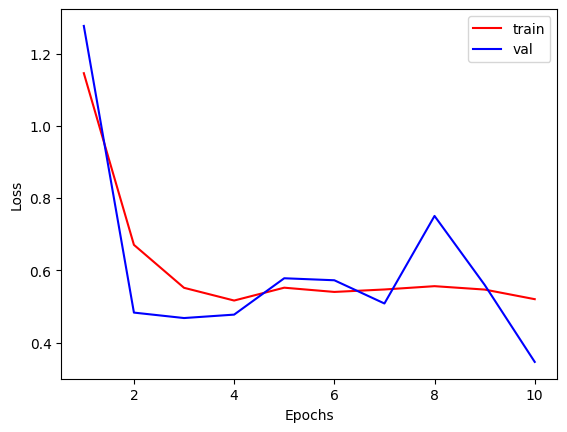

In [ ]:
epochs = [x+1 for x in range(num_epochs)]

plt.plot(epochs, train_loss_per_epoch, color='r', label='train')
plt.plot(epochs, val_loss_per_epoch, color='b', label='val')

plt.xlabel("Epochs")
plt.ylabel("Loss")

plt.legend()
plt.show()

## 6. Model Testing

In [ ]:
model = mobilenet_v3_small(pre_trained=False)
model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, num_classes)
model.load_state_dict(torch.load("mobilenetv3_small_lemon.pth"))
model.eval()

correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.8333


## 7. Exporting to .pkl

In [ ]:
model = torch.load("mobilenetv3_small_lemon.pth")

model_filename = "mobilenetv3_small_lemon.pkl"
pickle.dump(model, open(model_filename, 'wb'))